# **Credit Card Segmentation Analysis By Hierarchical Clustering**

In [ ]:
# import libraries
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18,7.27)})
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

**Objectve:** to develop customer segmentation based on existing criteries in case
to define the marketing strategy

**Data Source:** [link text](https://www.kaggle.com/arjunbhasin2013/ccdata)

**Credit Card dataset explanation:** we have the usage behavior of 9000 active credit cardholders with 18 columns/features

**Time period:** the information was collected within 6 months

**Limitations:** lack of industry-related personal

**Features:**


CUSTID : Identification of Credit Card holder (Categorical)

BALANCE : Balance amount left in their account to make purchases (

BALANCEFREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)

PURCHASES : Amount of purchases made from account

ONEOFFPURCHASES : Maximum purchase amount done in one-go

INSTALLMENTSPURCHASES : Amount of purchase done in installment

CASHADVANCE : Cash in advance given by the user

PURCHASESFREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)

ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)

PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)

CASHADVANCEFREQUENCY : How frequently the cash in advance being paid

CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"

PURCHASESTRX : Numbe of purchase transactions made

CREDITLIMIT : Limit of Credit Card for user

PAYMENTS : Amount of Payment done by user

MINIMUM_PAYMENTS : Minimum amount of payments made by user

PRCFULLPAYMENT : Percent of full payment paid by user

TENURE : Tenure of credit card service for user

In [ ]:
# loading dataset
path = "/content/drive/MyDrive/Colab Notebooks/data/5\
 - clustering/CC GENERAL.csv"
df = pd.read_csv(path)
df_original = df

df

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,C19187,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,NaN,0.000000,6
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


In [ ]:
# looking into info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

We can see that most columns in their proper stage (dtypes) beside the one: 'CUST_ID'. But we know that 'CUST_ID' is a column with a unique values for observation that has no further significance to our future prediction. So, we will drop it eventually. Also, we can see that two columns ('CREDIT_LIMIT' and 'MINIMUM_PAYMENTS') has some missing values. So, we need to deal with that before we will fit our data to the model.

In [ ]:
# let's see for duplicates in our dataset
df.duplicated().sum()

0

In [ ]:
# dropping irrelevant column
df = df.drop(columns=['CUST_ID'])
df.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

In [ ]:
# looking for missing values
df.isna().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

As we predicted, there are some missing values in our dataset within two columns. Let's observe them closer before we will decide which approach is more optimal option to deal with it.

In [ ]:
mask_1 = df['CREDIT_LIMIT'].isna()
df[mask_1]

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
5203,18.400472,0.166667,0.0,0.0,0.0,186.853063,0.0,0.0,0.0,0.166667,1,0,NaN,9.040017,14.418723,0.0,6


It looks like some individuals do not use or probably stop using a credit card at all. So, we will consider this case as an exception and will drop the whole row (without filling it with other value) because we do have enough sample size to work with.

In [ ]:
# double-checking if everything in order
df = df[~mask_1]
df['CREDIT_LIMIT'].isna().sum()

0

In [ ]:
# now let's take a look at 'MINIMUM_PAYMENT' column and see why we do have
# missing values there
mask_2 = df['MINIMUM_PAYMENTS'].isna()

print(len(df[mask_2]))
df[mask_2]

313


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.0,12
45,2242.311686,1.000000,437.00,97.00,340.0,184.648692,0.333333,0.083333,0.333333,0.166667,2,5,2400.0,0.000000,NaN,0.0,12
47,3910.111237,1.000000,0.00,0.00,0.0,1980.873201,0.000000,0.000000,0.000000,0.500000,7,0,4200.0,0.000000,NaN,0.0,12
54,6.660517,0.636364,310.00,0.00,310.0,0.000000,0.666667,0.000000,0.666667,0.000000,0,8,1000.0,417.016763,NaN,0.0,12
55,1311.995984,1.000000,1283.90,1283.90,0.0,0.000000,0.250000,0.250000,0.000000,0.000000,0,6,6000.0,0.000000,NaN,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8919,14.524779,0.333333,152.00,152.00,0.0,0.000000,0.333333,0.333333,0.000000,0.000000,0,2,1500.0,0.000000,NaN,0.0,6
8929,371.527312,0.333333,0.00,0.00,0.0,1465.407927,0.000000,0.000000,0.000000,0.166667,5,0,1500.0,0.000000,NaN,0.0,6
8935,183.817004,1.000000,465.90,0.00,465.9,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1500.0,0.000000,NaN,0.0,6
8944,193.571722,0.833333,1012.73,1012.73,0.0,0.000000,0.333333,0.333333,0.000000,0.000000,0,2,4000.0,0.000000,NaN,0.0,6


In [ ]:
df[mask_2].describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,0.0,313.0,313.000000
mean,555.441321,0.389403,393.087284,250.433387,142.653898,559.136698,0.336043,0.107886,0.244670,0.067169,1.460064,5.833866,3731.789137,322.286168,NaN,0.0,11.063898
std,1292.687887,0.408341,757.905701,624.453991,311.289043,1185.132567,0.372517,0.227370,0.359756,0.130087,3.182359,9.600908,2924.606153,1996.658905,NaN,0.0,1.869734
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,500.000000,0.000000,NaN,0.0,6.000000
25%,0.187069,0.090909,1.400000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1500.000000,0.000000,NaN,0.0,12.000000
50%,16.848358,0.181818,130.400000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,2.000000,3000.000000,0.000000,NaN,0.0,12.000000
75%,286.686616,1.000000,399.950000,176.030000,152.280000,480.104401,0.583333,0.083333,0.416667,0.083333,1.000000,8.000000,5000.000000,0.000000,NaN,0.0,12.000000
max,9164.724752,1.000000,7597.090000,6761.290000,2959.240000,7616.064965,1.000000,1.000000,1.000000,1.000000,21.000000,77.000000,19500.000000,29272.486070,NaN,0.0,12.000000


Looking at the statistical description above we can say that it does make sense if customers do not have 'Balance' on the credit cards they do not have 'Minimum' payments either. So, we deal with this case by replacing NaNs with 0.

In [ ]:
# looking at users that have zero balance on their credit cards
mask_3 = (df['BALANCE'] == 0) & (df['MINIMUM_PAYMENTS'].isna())
df[mask_3]

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
99,0.0,0.0,0.00,0.0,0.00,89.849004,0.000000,0.0,0.000000,0.142857,1,0,3000.0,138.021428,NaN,0.0,7
181,0.0,0.0,23.00,0.0,23.00,0.000000,0.083333,0.0,0.083333,0.000000,0,1,5000.0,0.000000,NaN,0.0,12
654,0.0,0.0,0.00,0.0,0.00,310.888779,0.000000,0.0,0.000000,0.083333,1,0,9000.0,0.000000,NaN,0.0,12
860,0.0,0.0,199.88,0.0,199.88,0.000000,0.750000,0.0,0.750000,0.000000,0,14,4000.0,0.000000,NaN,0.0,12
1131,0.0,0.0,12.65,0.0,12.65,0.000000,0.083333,0.0,0.083333,0.000000,0,1,5000.0,0.000000,NaN,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8191,0.0,0.0,52.50,0.0,52.50,0.000000,0.416667,0.0,0.416667,0.000000,0,5,3000.0,57.506797,NaN,0.0,12
8329,0.0,0.0,39.54,0.0,39.54,0.000000,0.166667,0.0,0.166667,0.000000,0,2,3000.0,181.014541,NaN,0.0,12
8404,0.0,0.0,64.62,0.0,64.62,0.000000,0.250000,0.0,0.250000,0.000000,0,3,1000.0,0.000000,NaN,0.0,12
8484,0.0,0.0,120.82,0.0,120.82,0.000000,0.500000,0.0,0.500000,0.000000,0,6,1000.0,275.029692,NaN,0.0,12


In [ ]:
# replacing NaNs with 0 value for those who have zero Balance on credit cards
df.loc[mask_3, 'MINIMUM_PAYMENTS'] = 0
df[mask_3]

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
99,0.0,0.0,0.00,0.0,0.00,89.849004,0.000000,0.0,0.000000,0.142857,1,0,3000.0,138.021428,0.0,0.0,7
181,0.0,0.0,23.00,0.0,23.00,0.000000,0.083333,0.0,0.083333,0.000000,0,1,5000.0,0.000000,0.0,0.0,12
654,0.0,0.0,0.00,0.0,0.00,310.888779,0.000000,0.0,0.000000,0.083333,1,0,9000.0,0.000000,0.0,0.0,12
860,0.0,0.0,199.88,0.0,199.88,0.000000,0.750000,0.0,0.750000,0.000000,0,14,4000.0,0.000000,0.0,0.0,12
1131,0.0,0.0,12.65,0.0,12.65,0.000000,0.083333,0.0,0.083333,0.000000,0,1,5000.0,0.000000,0.0,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8191,0.0,0.0,52.50,0.0,52.50,0.000000,0.416667,0.0,0.416667,0.000000,0,5,3000.0,57.506797,0.0,0.0,12
8329,0.0,0.0,39.54,0.0,39.54,0.000000,0.166667,0.0,0.166667,0.000000,0,2,3000.0,181.014541,0.0,0.0,12
8404,0.0,0.0,64.62,0.0,64.62,0.000000,0.250000,0.0,0.250000,0.000000,0,3,1000.0,0.000000,0.0,0.0,12
8484,0.0,0.0,120.82,0.0,120.82,0.000000,0.500000,0.0,0.500000,0.000000,0,6,1000.0,275.029692,0.0,0.0,12


In [ ]:
# now, let's take a look at others who have NaNs in their MINUMUM_PAYMENT
mask_4 = df['MINIMUM_PAYMENTS'].isna()
df[mask_4]

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.0,12
45,2242.311686,1.000000,437.00,97.00,340.0,184.648692,0.333333,0.083333,0.333333,0.166667,2,5,2400.0,0.000000,NaN,0.0,12
47,3910.111237,1.000000,0.00,0.00,0.0,1980.873201,0.000000,0.000000,0.000000,0.500000,7,0,4200.0,0.000000,NaN,0.0,12
54,6.660517,0.636364,310.00,0.00,310.0,0.000000,0.666667,0.000000,0.666667,0.000000,0,8,1000.0,417.016763,NaN,0.0,12
55,1311.995984,1.000000,1283.90,1283.90,0.0,0.000000,0.250000,0.250000,0.000000,0.000000,0,6,6000.0,0.000000,NaN,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8919,14.524779,0.333333,152.00,152.00,0.0,0.000000,0.333333,0.333333,0.000000,0.000000,0,2,1500.0,0.000000,NaN,0.0,6
8929,371.527312,0.333333,0.00,0.00,0.0,1465.407927,0.000000,0.000000,0.000000,0.166667,5,0,1500.0,0.000000,NaN,0.0,6
8935,183.817004,1.000000,465.90,0.00,465.9,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1500.0,0.000000,NaN,0.0,6
8944,193.571722,0.833333,1012.73,1012.73,0.0,0.000000,0.333333,0.333333,0.000000,0.000000,0,2,4000.0,0.000000,NaN,0.0,6


In [ ]:
df[mask_4].describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,0.0,239.0,239.000000
mean,727.418969,0.509971,444.177573,315.129205,129.048368,725.039561,0.274402,0.132949,0.163118,0.084432,1.874477,5.447699,3940.376569,252.333524,NaN,0.0,10.899582
std,1437.005294,0.396033,848.092106,695.872333,331.711073,1312.457923,0.344879,0.246339,0.304281,0.143568,3.537455,10.417159,3176.921020,2026.768003,NaN,0.0,2.007957
min,0.006651,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,500.000000,0.000000,NaN,0.0,6.000000
25%,7.942038,0.133929,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1500.000000,0.000000,NaN,0.0,11.000000
50%,68.105410,0.333333,115.700000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,2.000000,3000.000000,0.000000,NaN,0.0,12.000000
75%,674.967115,1.000000,471.460000,308.485000,101.040000,1002.621491,0.333333,0.142857,0.133929,0.125000,2.000000,6.000000,5000.000000,0.000000,NaN,0.0,12.000000
max,9164.724752,1.000000,7597.090000,6761.290000,2959.240000,7616.064965,1.000000,1.000000,1.000000,1.000000,21.000000,77.000000,19500.000000,29272.486070,NaN,0.0,12.000000


By looking at the statistical results above, it's hard to get the main reasons why these types of customers that have some 'Balance' on their credit cards do not have 'Minimum Payment'. This is exactly the perfect time to address the current issue to industry professionals. It could be due to a glitch in the system or it's done on purpose based on some exemptions. Unfortunately, it's one of the mysteries we cannot resolve on a spot properly. Because our resources are limited for this project, we will be assuming that these all people do not have 'Minimum payment' due to its recent purchase (purchase was made within the past few days). So, the system was not able to process on time the most recent transactions to come up with 'Minumum payment'. In this case, we will replace all NaNs with zeros as well.

In [ ]:
df.loc[mask_4, 'MINIMUM_PAYMENTS'] = 0
df.isna().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

All right, now everything in order. 

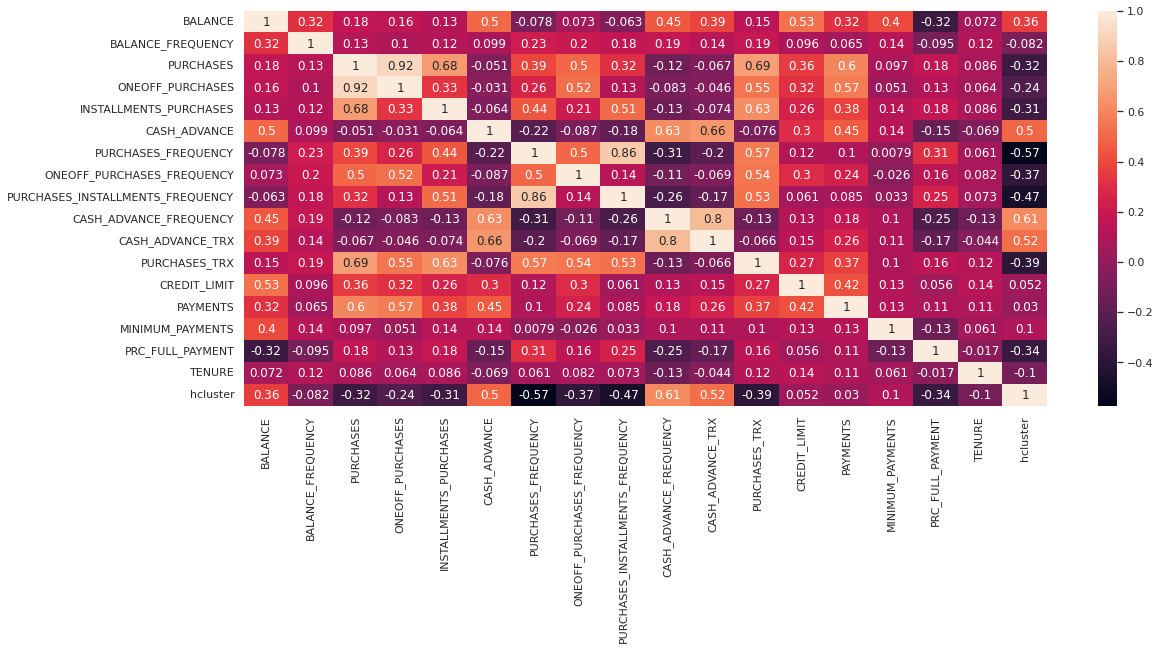

In [ ]:
# it's time to look at correlation among features
sns.set(rc={'figure.figsize':(18,7.27)})
_ = sns.heatmap(df.corr(), annot=True)
plt.show()

From the graph above, we could come up with many comments that depend on the intention of the company's needs and main objectives. Here, we will state a few things: first of all, those who have a balance on their credit card have balances for a long period of time. It's a vague statement that could be argued, but we are speaking here in a general way with some assumptions. Secondly, those who have 'BALANCE' are also more affected by the idea of withdrawing 'CASH_ADVANCE' more often.  Finally, we can say that those with balances (most of the time) have higher 'Credit limits' (again we are talking here more generally, but we will see if we are right later on).

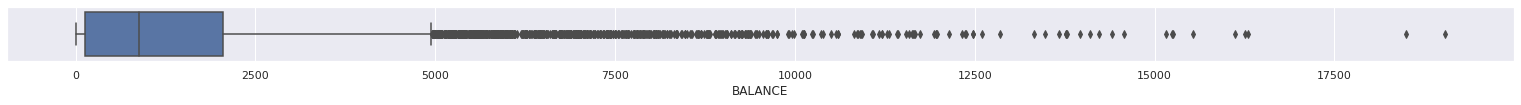

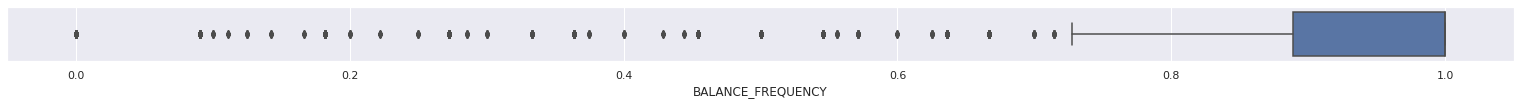

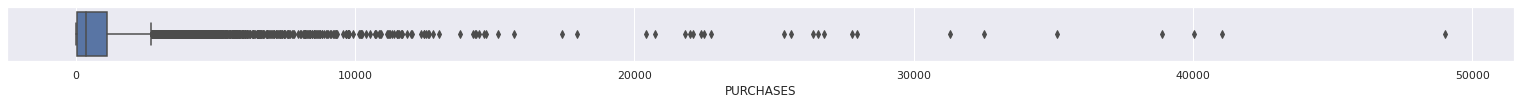

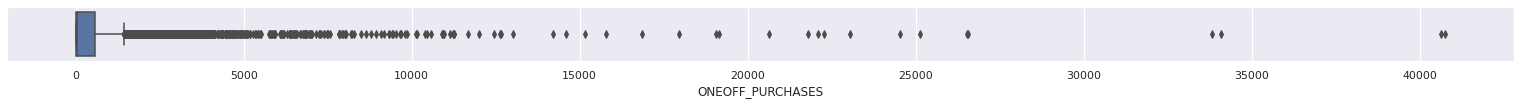

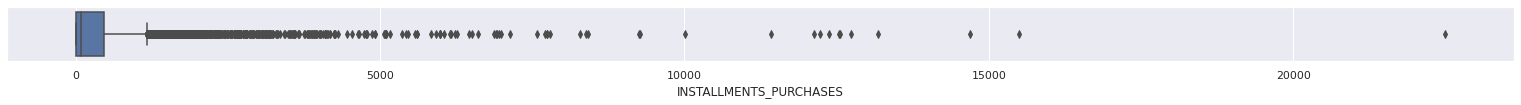

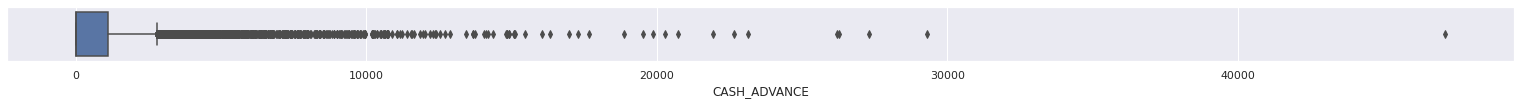

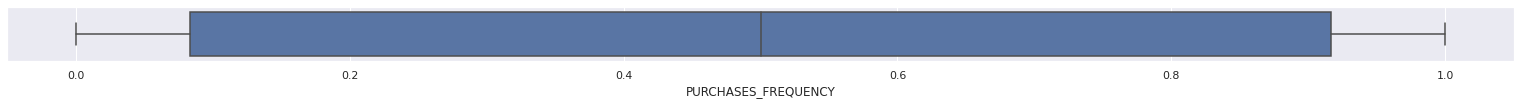

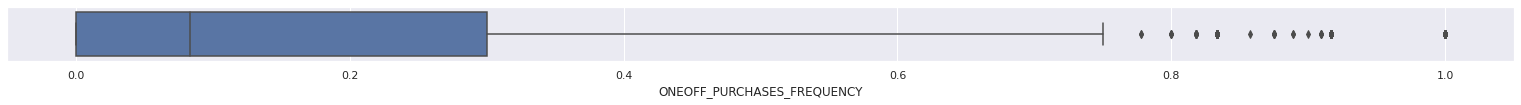

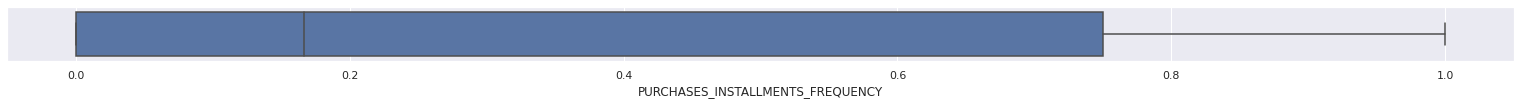

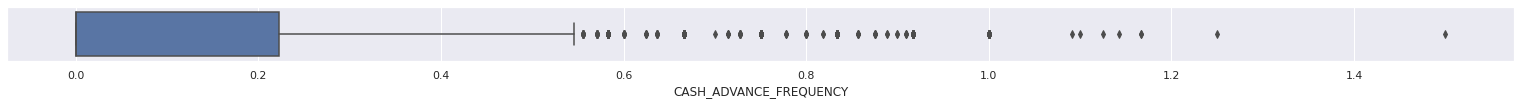

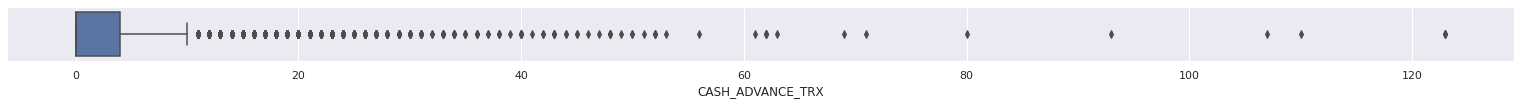

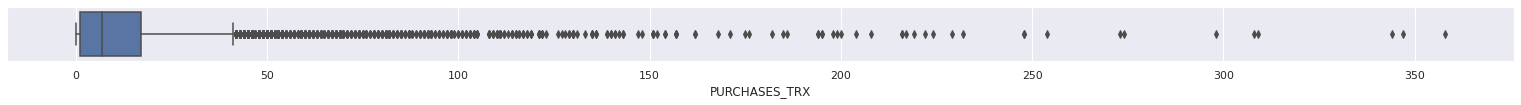

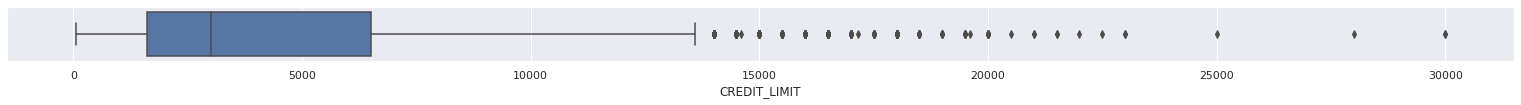

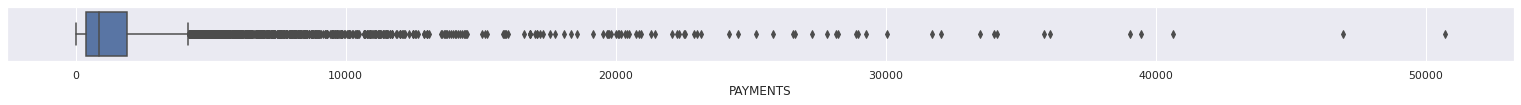

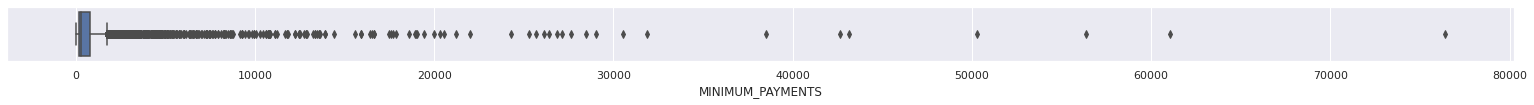

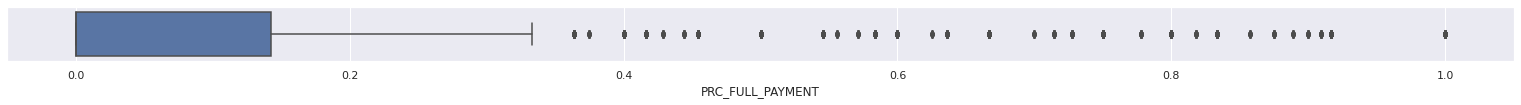

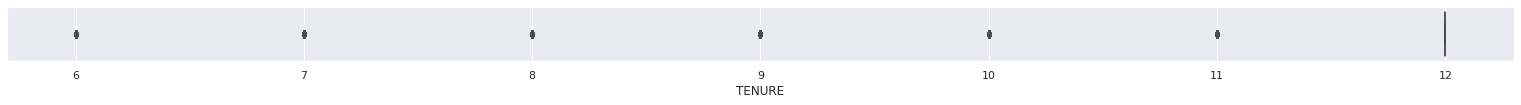

In [ ]:
# it's time to see if we do have outliers in our dataset
sns.set(rc={'figure.figsize':(27,1)})
for i in df.columns:
  _ = sns.boxplot(x=df[i])
  plt.show()

Hmm, that looks not good. We do have outliers almost in each feature/column. As we know, clustering models like K-Means and Hierarchical Clustering do not go along with outliers. By removing them, we will decrease significantly our sample size that poorly will affect our cluster detection results. Let's stick with whatever we have for now and deal with that later on if it will be a necessary action.

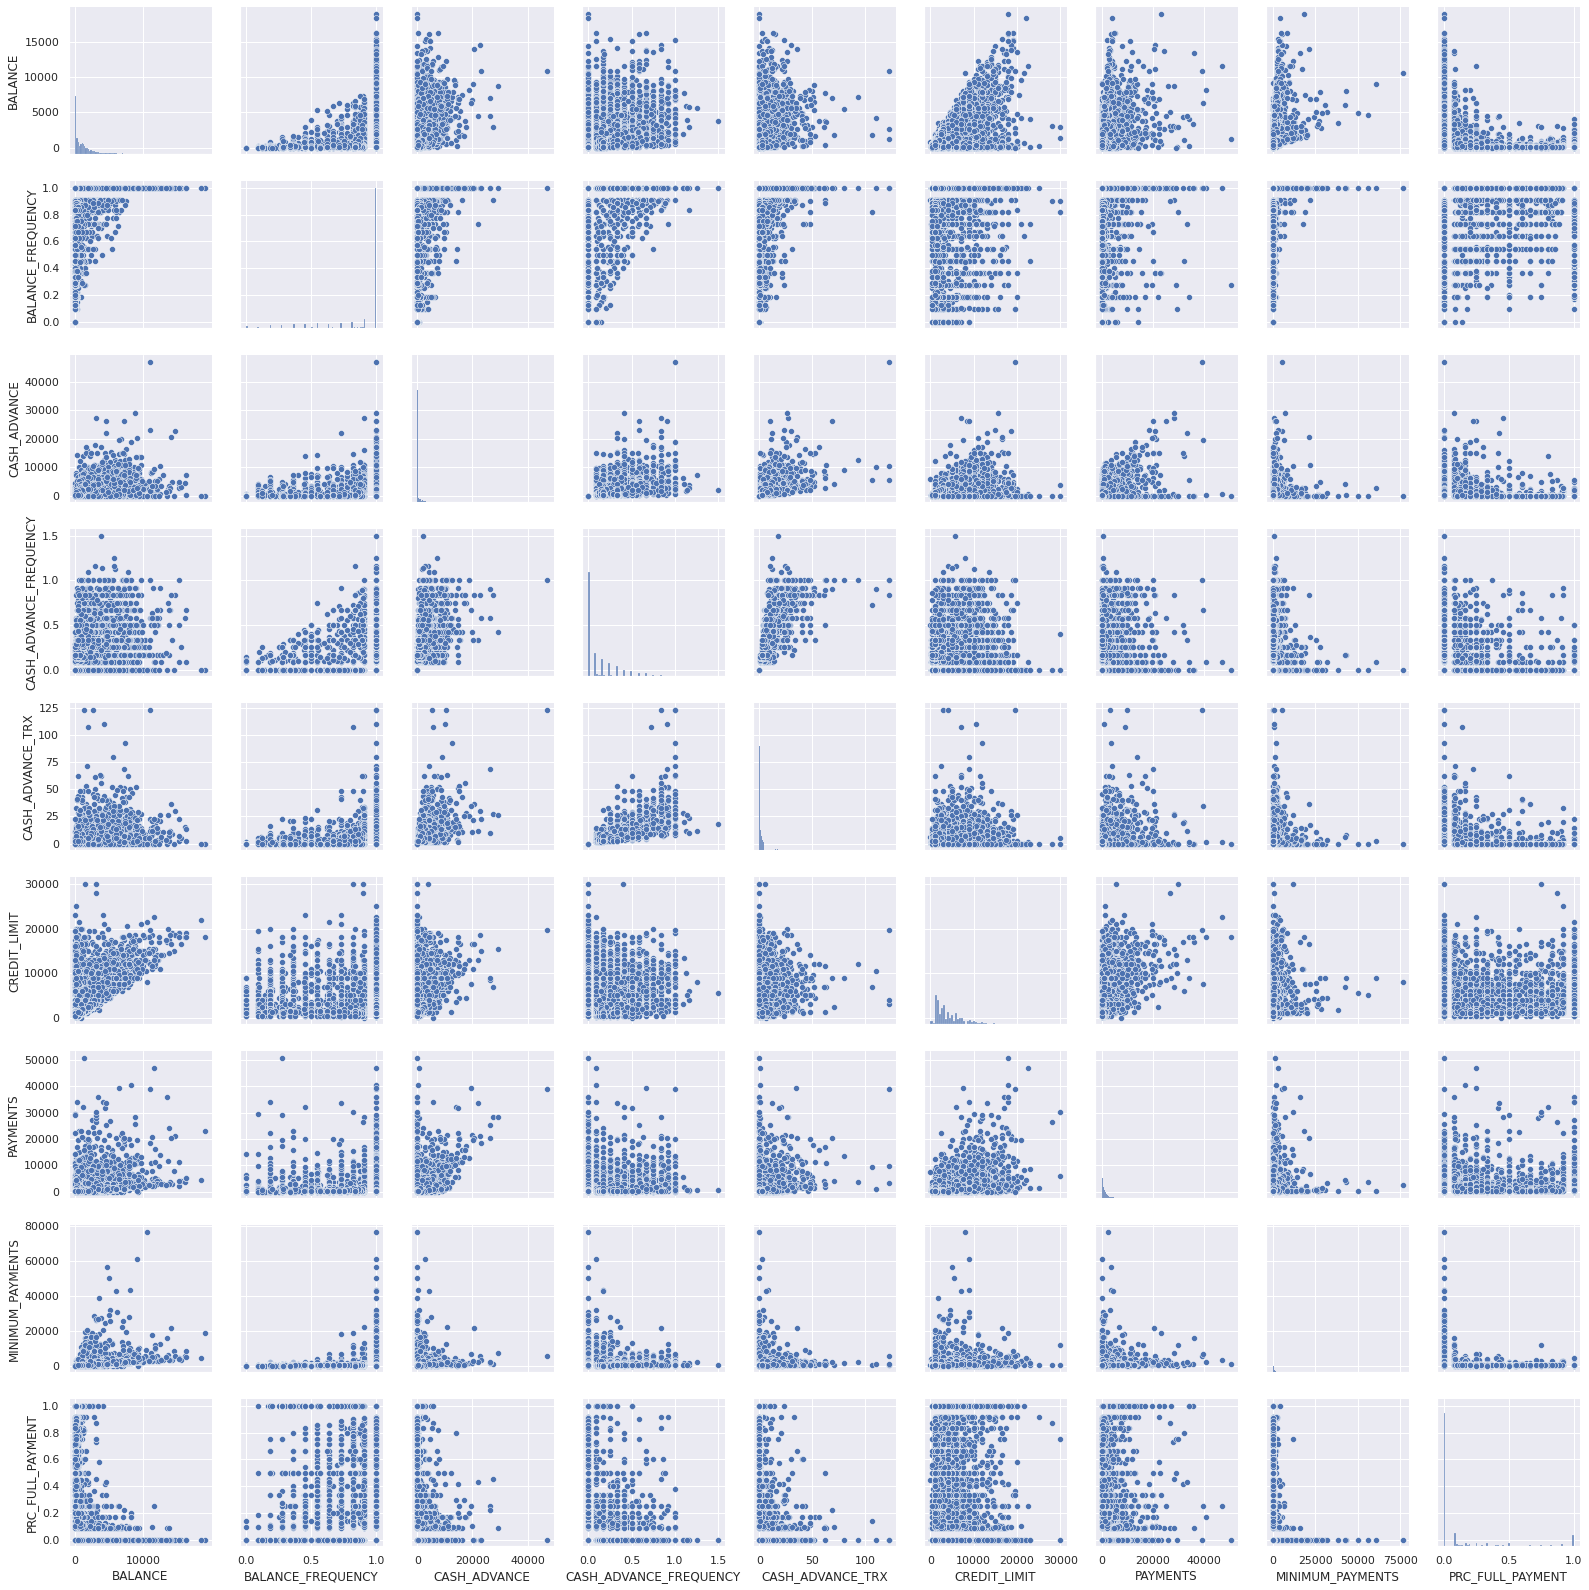

In [ ]:
# it's time to look at pairplot
sns.set(rc={'figure.figsize':(20,10)})
_ = sns.pairplot(df[['BALANCE', 'BALANCE_FREQUENCY', 
       'CASH_ADVANCE',     
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']])
plt.show()

In the graph above we can see that some features (like 'Balance Frequency' or 'Credit Limit') are highly correlated to the 'BALANCE' column. 

In [ ]:
# let's take a look at the distribution and scale of our data
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000
mean,1564.647593,0.877350,1003.316936,592.503572,411.113579,978.959616,0.490405,0.202480,0.364478,0.135141,3.249078,14.711476,4494.449450,1733.336511,834.075035,0.153732,11.517935
std,2081.584016,0.236798,2136.727848,1659.968851,904.378205,2097.264344,0.401360,0.298345,0.397451,0.200132,6.824987,24.858552,3638.815725,2895.168146,2336.104378,0.292511,1.337134
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,6.000000
25%,128.365782,0.888889,39.800000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.282850,163.029483,0.000000,12.000000
50%,873.680279,1.000000,361.490000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,857.062706,289.686899,0.000000,12.000000
75%,2054.372848,1.000000,1110.170000,577.830000,468.650000,1113.868654,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.279320,788.721609,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


From statistical analysis above we can see that most of our features are on different scale units. So, before we will fit our dataset to our model we need to Scale them.

In [ ]:
# applying standard-scaler to our dataset
sc = StandardScaler()
df_scaled = sc.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.732054,-0.249881,-0.424934,-0.356957,-0.349114,-0.466805,-0.806649,-0.678716,-0.707409,-0.675294,-0.476083,-0.511381,-0.960380,-0.529026,-0.297334,-0.525588,0.360541
1,0.786858,0.134049,-0.469584,-0.356957,-0.454607,2.605438,-1.221928,-0.678716,-0.917090,0.573949,0.110032,-0.591841,0.688601,0.818546,0.101998,0.234159,0.360541
2,0.447041,0.517980,-0.107716,0.108843,-0.454607,-0.466805,1.269742,2.673295,-0.917090,-0.675294,-0.476083,-0.109082,0.826016,-0.383857,-0.088524,-0.525588,0.360541
3,0.049015,-1.017743,0.231995,0.546123,-0.454607,-0.368678,-1.014290,-0.399383,-0.917090,-0.258882,-0.329554,-0.551611,0.826016,-0.598733,-0.357057,-0.525588,0.360541
4,-0.358849,0.517980,-0.462095,-0.347317,-0.454607,-0.466805,-1.014290,-0.399383,-0.917090,-0.675294,-0.476083,-0.551611,-0.905414,-0.364421,-0.252265,-0.525588,0.360541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8944,-0.738015,0.517980,-0.333331,-0.356957,-0.132688,-0.466805,1.269742,-0.678716,1.179720,-0.675294,-0.476083,-0.350461,-0.960380,-0.486266,-0.336129,1.183844,-4.126919
8945,-0.742488,0.517980,-0.329174,-0.356957,-0.122869,-0.466805,1.269742,-0.678716,1.179720,-0.675294,-0.476083,-0.350461,-0.960380,-0.503445,-0.357057,-0.525588,-4.126919
8946,-0.740463,-0.185895,-0.402000,-0.356957,-0.294930,-0.466805,0.854463,-0.678716,0.760359,-0.675294,-0.476083,-0.390691,-0.960380,-0.570660,-0.321774,0.329128,-4.126919
8947,-0.745239,-0.185895,-0.469584,-0.356957,-0.454607,-0.449373,-1.221928,-0.678716,-0.917090,0.157536,-0.183026,-0.591841,-1.097795,-0.580581,-0.333188,0.329128,-4.126919


Our data is scaled, and now we are ready to apply the Hierarchical clustering algorithm. Let's mention that, there are two types of Hierarchical clustering approaches: agglomerative and divisive. Here, we will be applying Agglomerative clustering that starts building clusters based on their similarity from 'bottom-up'. Agglomerative clustering gets the idea wherein its first stage every observation is a cluster.

In [ ]:
# performing hierarchical/agglomerative clustering
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
Z = linkage(df_scaled, 'ward')

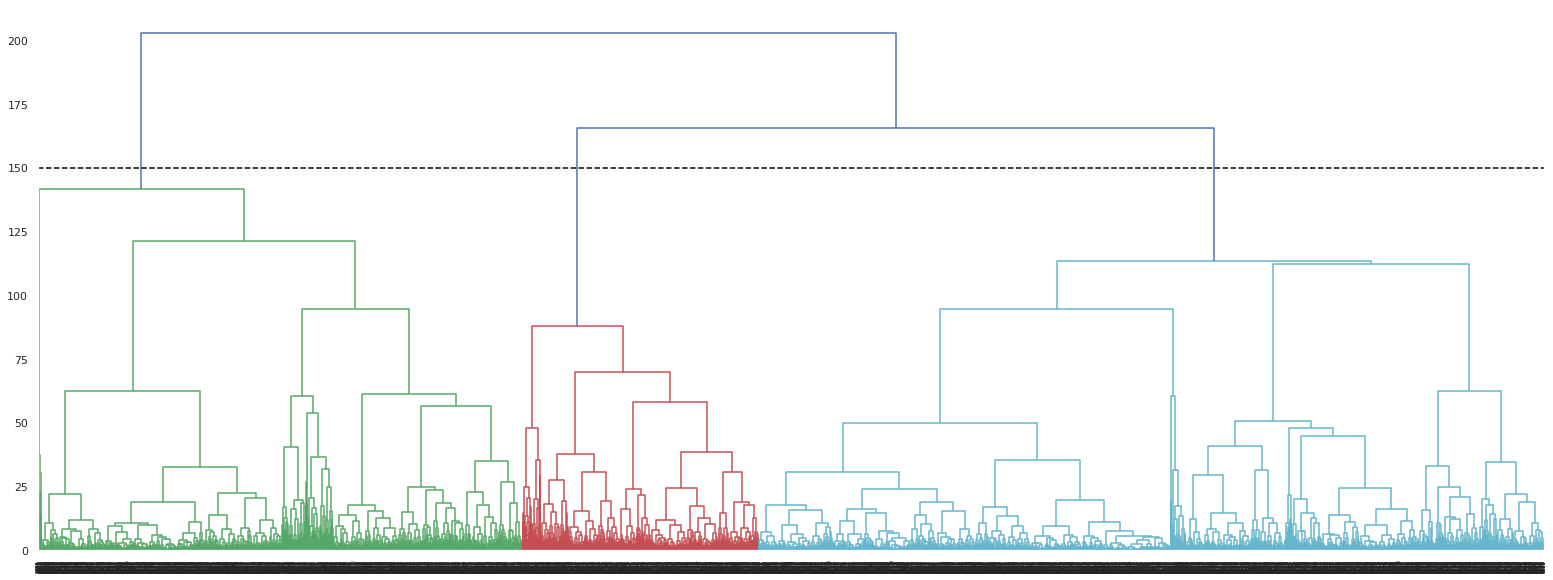

In [ ]:
# visualizing our results using 'dendrogram' diagram
sns.set(rc={'figure.figsize':(27,10)})
dn = dendrogram(Z)
plt.hlines(y = 150,  colors='black', xmin = 0, 
           xmax = df_scaled.shape[0] * df_scaled.shape[1] , linestyles='dashed')
plt.show()

From the graph above, we can see a few things: the minimum number of clusters we can have is 2, but based on the varieties of colors the optimum provided choice is 3. Thereby, we will stick with 3 clusters for now. Also, we should mention that our dendrogram slightly is affected by the existence of outliers. So, if we would like to improve the results we could consider dealing with before or after.

In [ ]:
# Agglomerative Clustering - getting labels
# recursively merges pair of clusters of sample data; uses linkage distance
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
model_1 = AgglomerativeClustering(n_clusters=3, affinity='euclidean',
                                  linkage='ward')

In [ ]:
# clustering labels for each point
model_1_labels = model_1.fit_predict(df_scaled)
model_1_labels

array([1, 2, 0, ..., 1, 1, 1])

In [ ]:
# adding labels to our original dataset
df['hcluster'] = model_1_labels
df

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,hcluster
0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,1
1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,2
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0
3,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,0.000000,0.000000,12,1
4,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6,1
8946,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,0.000000,0.000000,6,1
8947,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6,1
8948,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6,1


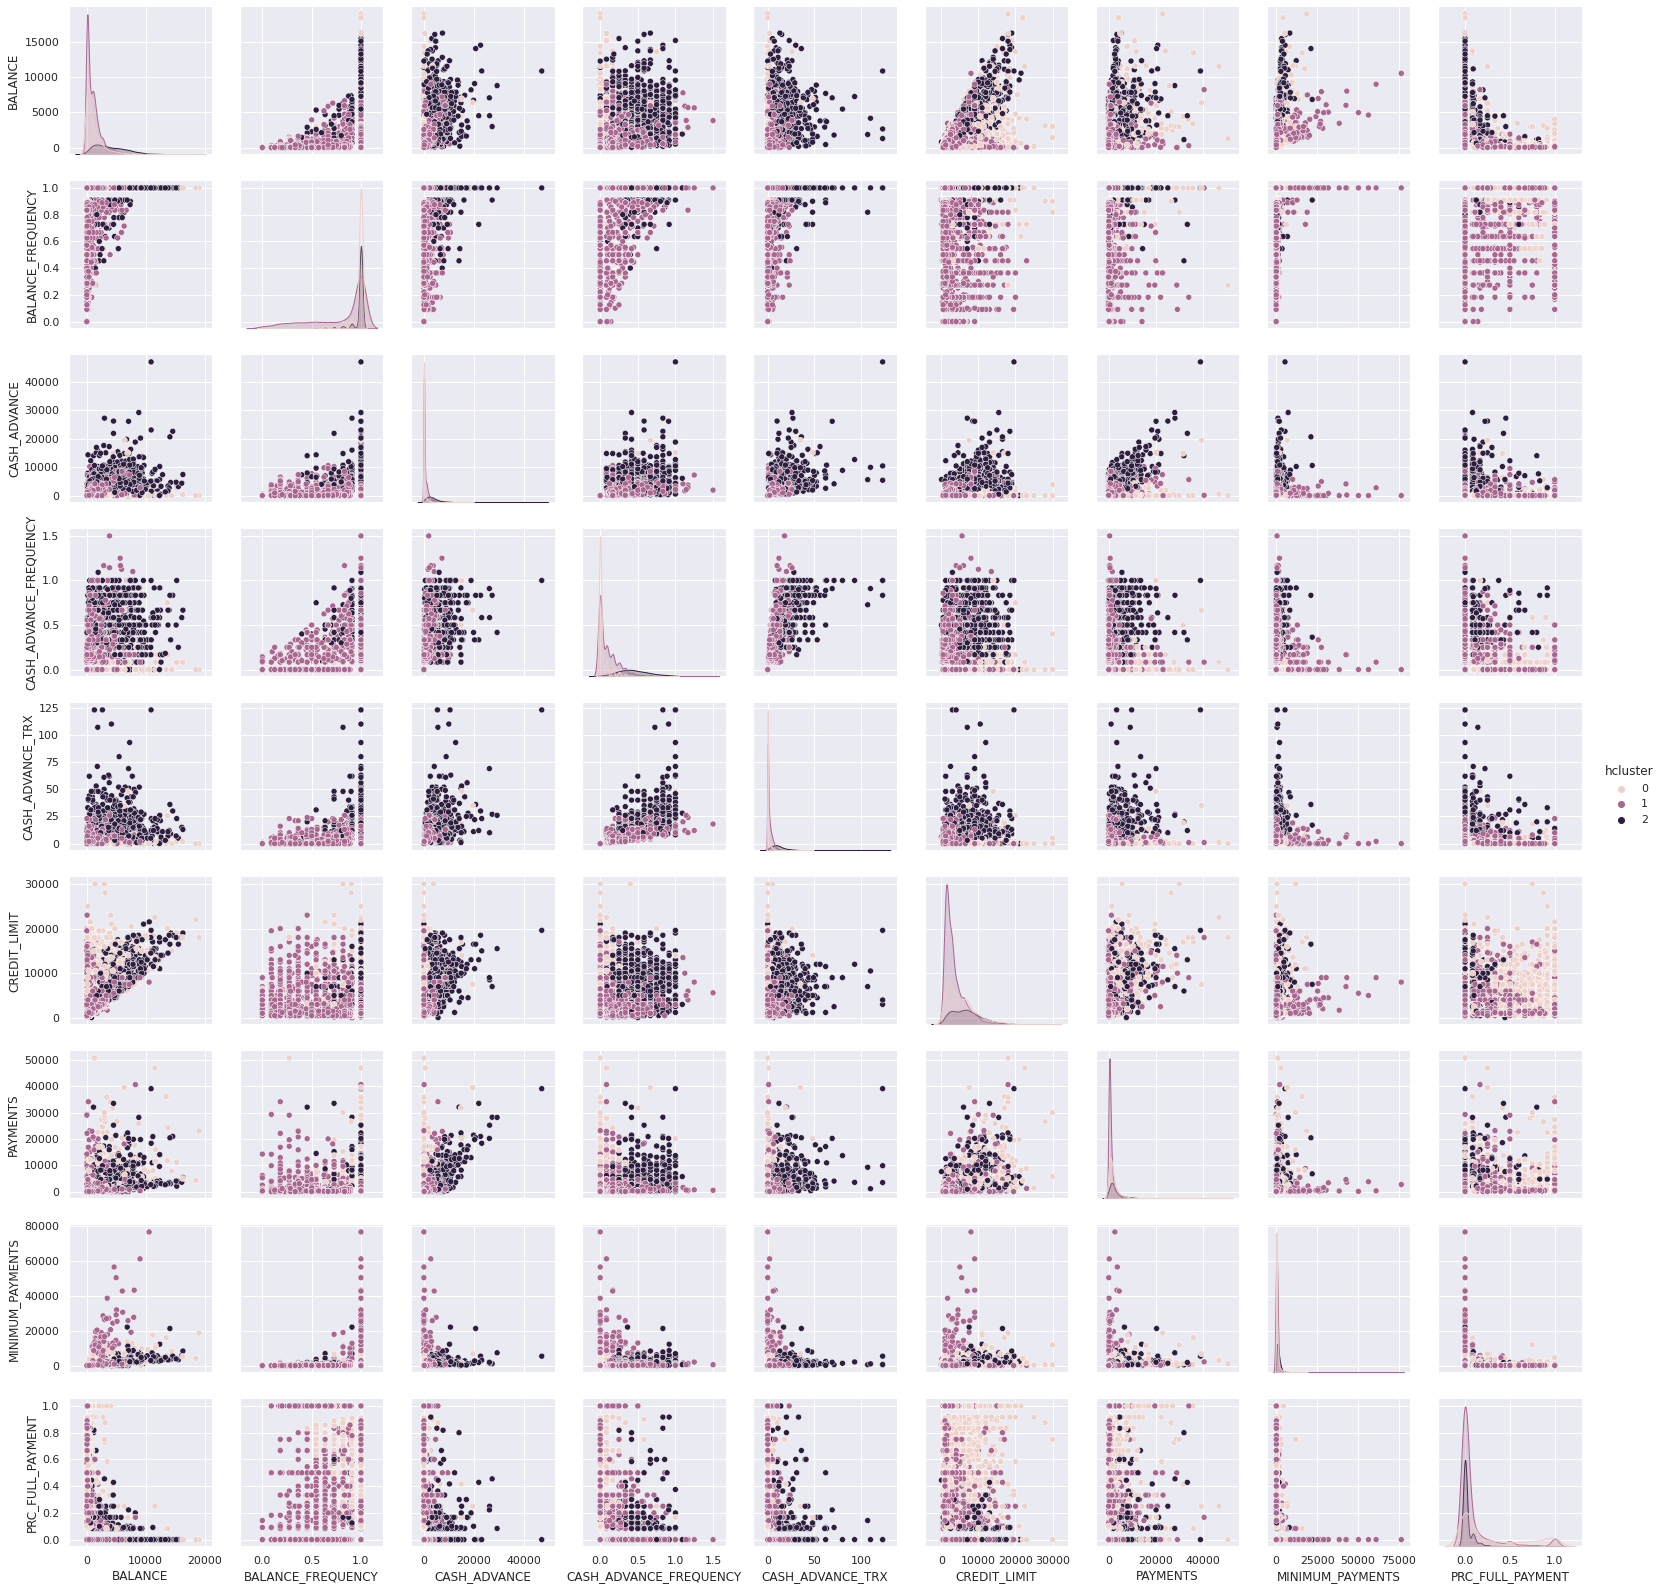

In [ ]:
# it's time to look at our results using pair plot
sns.set(rc={'figure.figsize':(20,10)})
_ = sns.pairplot(df[['BALANCE', 'BALANCE_FREQUENCY', 
       'CASH_ADVANCE',  'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
        'hcluster']],
       hue='hcluster')
plt.show()

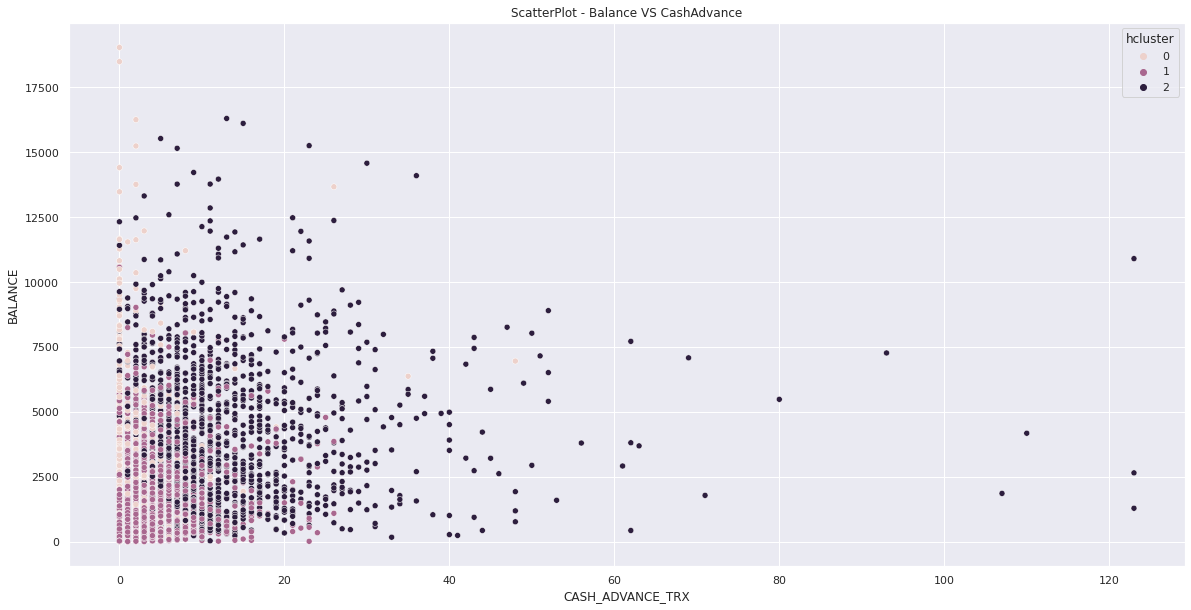

In [ ]:
_ = sns.scatterplot(data=df, x='CASH_ADVANCE_TRX', y='BALANCE',
                      hue='hcluster')
_ = plt.title('ScatterPlot - Balance VS CashAdvance')
plt.show()

From the graph above we can say that in some places there is big overlapping. So, using Agglomerative Clustering is not the best choice here. There could be better options. Nevertheless, we still can make some assumptions on provided results. For example: those who have a higher balance, stay with that balance for a longer period of time (as we mentioned before). Also, these type of people is more influenced by taking 'cash advance' and putting themself for a higher APR. Additionally, we can state that banks 'aggressively' target this type of group by increasing their 'credit limit' (and giving the opportunity to get further in financial trouble). We do have interesting phenomena if we look closely at 'Balance' and 'Minimum payment' we will see that banks are willing to lower the minimum payment despite the high 'Balance' just to make sure the customer stays longer in debt (guess the whole business is built on this idea). Thereby, we would say that advertising companies should follow the bank's footsteps and target the group of people that on average have a higher balance for an extended period of time and have a bad habit of taking 'cash_advance' more frequently (compare to other groups) despite a higher rate. In this scenario, the proper group to target is number 2.